In [2]:
from SPM import subspace_power_method
import numpy as np
from PyMoments import kstat
from itertools import permutations
from scipy.optimize import minimize
from scipy.stats import uniform_direction
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline

In [3]:
def recovermixingmatrix(I,J,observeddata):
    # generate the second and fourth cumulant tensors
    second_order_kstats = np.zeros((I, I))
    fourth_order_kstats=np.zeros((I,I,I,I))
    for i in range(I):
        for j in range(I):
            second_order_kstats[i,j]=kstat(observeddata,(i,j))
    for i in range(I):
        for j in range(I):
            for k in range(I):
                for l in range(I):
                    fourth_order_kstats[i,j,k,l]=kstat(observeddata,(i,j,k,l))
    # recover first J-1 columns via tensor decomposition
    cols,lambdas=subspace_power_method(fourth_order_kstats,n=4,d=I,r=J-1)
    def returnmindistancebewteenvectors(cols):
        def distancebewteenvectors(v1,v2):
            v1=v1.reshape(-1,1)
            v2=v2.reshape(-1,1)
            M=v1@np.transpose(v1)-v2@np.transpose(v2)
            return np.sum(M*M)
        lens=cols.shape[1]
        error=1
        for i in range(lens):
            for j in range(i+1,lens):
                error=min(error,distancebewteenvectors(cols[:,i],cols[:,j]))
        return error
    step=0
    while returnmindistancebewteenvectors(cols)<0.1 and step<100:
        cols,lambdas=subspace_power_method(fourth_order_kstats,n=4,d=I,r=J-1)
        step+=1
    
    # now we use second cumulant to find the last column of the mixing matrix 
    # by minimizing the distance bewteen a matrix in the linear span of the second cumulant matrix 
    # and all the rank 1 matrices M_1,...M_{J-1} obtained from the first J-1 columns of A
    rank1_matrixlist=[]
    for i in range(J-1):
        vector=cols[:,i].reshape(-1,1)
        matrix=vector@ np.transpose(vector)
        rank1_matrixlist.append(matrix)
    
    #function returning the distance between second_order_kstats-l_1*M_1-...-l_{J-1}*M_{J-1} and v\otimes v
    # input is the vector (l|v)
    def sumofsquare(x):
        l=x[:J]
        v=x[J:]
        v=v.reshape(-1,1)
        n=len(l)
        M=second_order_kstats
        for i in range(n-1):
            M=M-l[i]*rank1_matrixlist[i]
        M=M-l[-1]*v@np.transpose(v)
        return np.sum(M*M)
    #initialize a random start point
    l0= np.random.randn(J).reshape(-1,1)
    v0 = np.transpose(uniform_direction(I).rvs(1))
    x=np.vstack((l0,v0)).reshape(-1)
    # optimizition
    es = minimize(sumofsquare, x, method='Powell')
    # recover last column of A
    v=es.x[J:]/np.linalg.norm(es.x[J:])
    #recover A up to permutation and sign
    estimateA=np.hstack((cols,v.reshape(-1,1)))
    return estimateA

In [4]:
# generate simulated data

# generate the sources, all but the last one are exponential distribution with parameter one and the last one is standard Gaussian
def observeddata(samplesize,I,J):
    sourcelist=[]
    for i in range(J-1):
        sourcelist.append(np.random.exponential(1,samplesize))
    sourcelist.append(np.random.normal(0,1,samplesize))
    sourcedata=np.transpose(np.vstack(tuple(sourcelist)))

    # generate a random mixing matrix with columns having norm 1
    uniformsphere=uniform_direction(I)
    A=np.transpose(uniformsphere.rvs(J))

    # mix the sources
    observeddata=np.transpose(A @ np.transpose(sourcedata))
    return A,observeddata

# function testing how well is the approximation
def similarity_measures(B,A):
    J=A.shape[1]
    columnlist=[]
    for i in range(J):
        v=A[:,i]
        dislist=[]
        signlist=[]
        for j in range(B.shape[1]):
            u=abs(v-B[:,j])
            uprime=abs(v+B[:,j])
            sign=1
            if np.sum(u)<np.sum(uprime):
                dislist.append(np.sum(u))
                signlist.append(sign)
            else:
                sign=-1
                dislist.append(np.sum(uprime))
                signlist.append(sign)
        a=min(dislist)
        index=dislist.index(a)
        sign=signlist[index]
        columnlist.append(sign*B[:,index])
        B=np.delete(B,index,1)
    newAes=np.transpose(np.vstack(tuple(columnlist)))
    C= newAes-A
    relfroberror=(np.sum(C*C)/J)**0.5
    froberror=(np.sum(C*C))**0.5
    cosine_similarity=np.mean(np.sum(newAes*A,axis=0))
    last_column_cosine_similarity=np.sum(newAes[:,-1]*A[:,-1])
    # for now the bound is 0.95
    if last_column_cosine_similarity>=0.95:
        succesfulflag_last_column=1
    else:
        succesfulflag_last_column=0
    return last_column_cosine_similarity,cosine_similarity,relfroberror,froberror,succesfulflag_last_column,newAes,A


#apply algorithm
def algorithm(I,J,samplesize):
    (A,data)=observeddata(samplesize,I,J)
    estimateA=recovermixingmatrix(I,J,data)
    return similarity_measures(estimateA,A)

def algorithm_allJ(I,Jlist,samplesize):
    last_row_cosine_similaritylist=[]
    relative_frobneuserror_list=[]
    frobneuserror_list=[]
    successful_list=[]
    for J in Jlist:
        print(J)
        (last_column_cosine_similarity,cosine_similarity,relfroberror,froberror,succesfulflag_last_column,newAes,A)=algorithm(I,J,samplesize)
        last_row_cosine_similaritylist.append(last_column_cosine_similarity)
        relative_frobneuserror_list.append(relfroberror)
        frobneuserror_list.append(froberror)
        successful_list.append(succesfulflag_last_column)
    return last_row_cosine_similaritylist,relative_frobneuserror_list,frobneuserror_list,successful_list




In [5]:
Iequals4Jlist=list(range(2,13))
Iequals5Jlist=list(range(2,18))
Iequals6Jlist=list(range(2,24))
Iequals7list=list(range(2,31))
Iequals8list=list(range(2,39))
def plot_graphs(I,Jlist,n_iter,samplesize,n_jobs):
    output=Parallel(n_jobs=n_jobs)(delayed(algorithm_allJ)(I,J,samplesize) for I,J,samplesize in [(I,Jlist,samplesize)]*n_iter)
    last_column_cosine_similaritylistlist,relfroberrorlistlist,froberrorlistlist,succesfulflag_last_columnlistlistlist=zip(*output)
    last_row_cosine_similarityarry=np.array(last_column_cosine_similaritylistlist)
    relative_frobneuserror_listarray=np.array(relfroberrorlistlist)
    frobneuserror_listarray=np.array(froberrorlistlist)
    successful_listarray=np.array(succesfulflag_last_columnlistlistlist)
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(18,18))
    ax1.boxplot(relative_frobneuserror_listarray)
    ax2.boxplot(last_row_cosine_similarityarry)
    ax3.boxplot(frobneuserror_listarray)
    ax4.bar(Jlist,np.sum(successful_listarray/n_iter,axis=0))
    ax1.set_xticklabels(Jlist)
    ax2.set_xticklabels(Jlist)
    ax3.set_xticklabels(Jlist)
    ax4.set_xticks(Jlist)
    ax1.set_title(f'relative_frobneuserror')
    ax2.set_title(f'last_column_cosine_similarity')
    ax3.set_title(f'frobeuserror')
    ax4.set_title(f'successful_rate')
    plt.savefig(f'/Users/kexinwang/Documents/harvard /research/ICA/plots/I={I},n_iter={n_iter},samplesize={samplesize}')



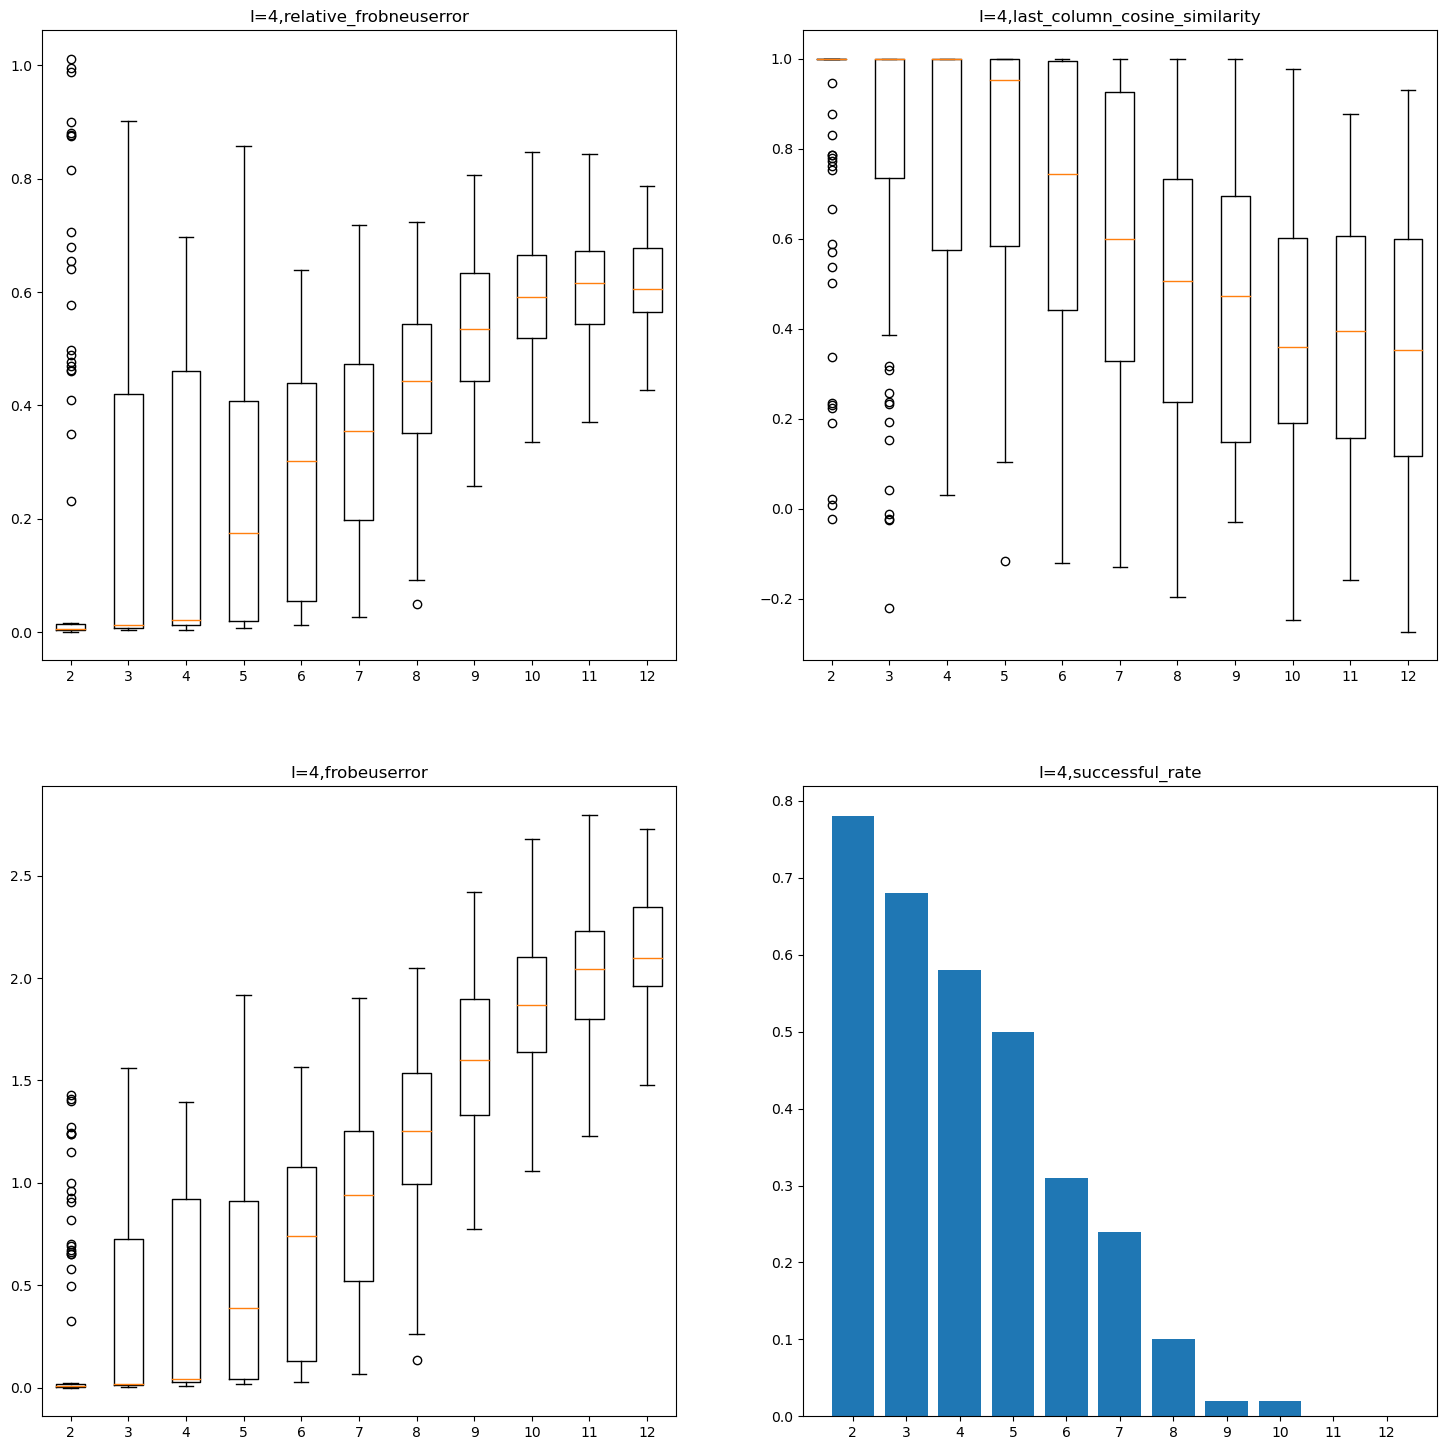

In [185]:
I=4
Jlist=Iequals4Jlist
n_iter=100
samplesize=100000
plot_graphs(I,Jlist,n_iter,samplesize,20)

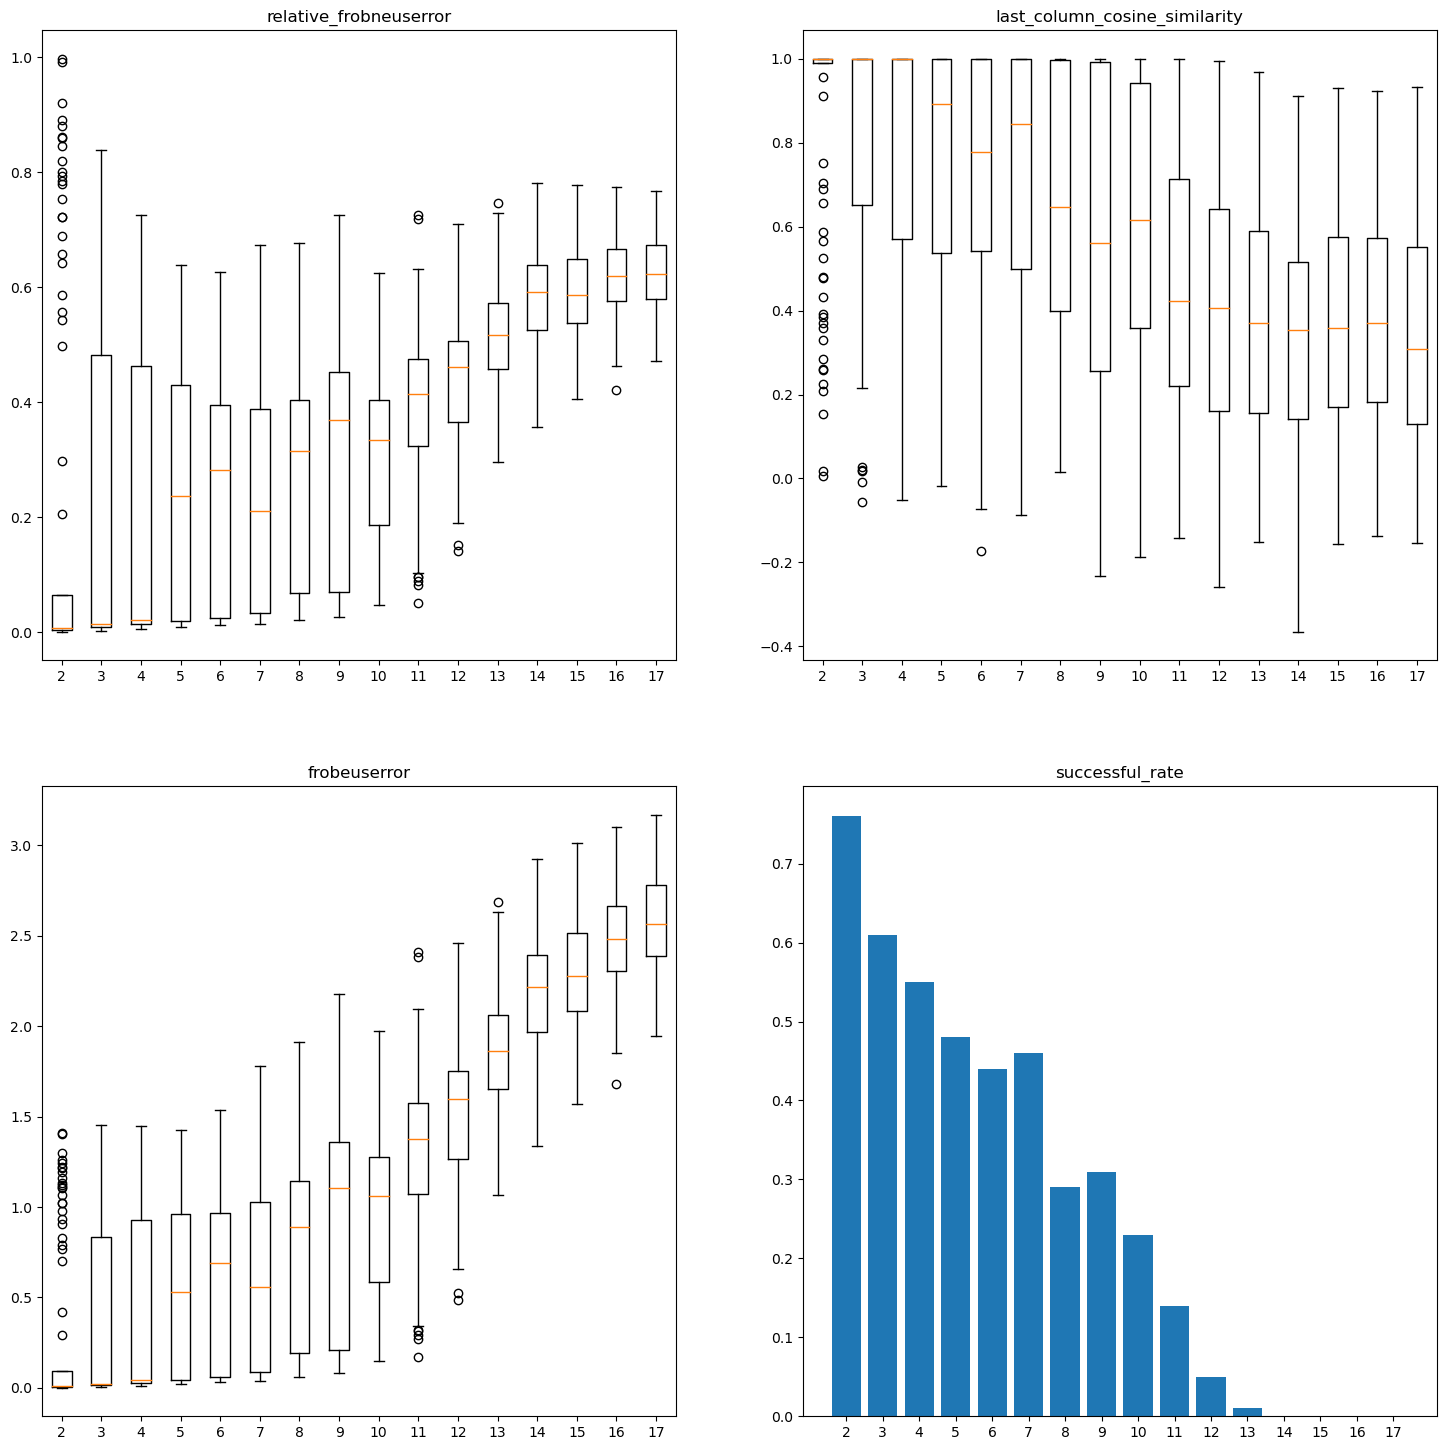

In [5]:
I=5
Jlist=Iequals5Jlist
n_iter=100
samplesize=100000
plot_graphs(I,Jlist,n_iter,samplesize,20)

2
2
2
2
2
3
3
3
3
3
4
4
4
4
4
5
5
5
5
5
6
6
6
6
6
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
10
10
10
10
10
11
11
11
11
11
12
12
12
12
12
13
13
13
14
13
14
14
13
14
15
14
15
15
15
16
16
15
16
17
17
17
16
18
16
18
18
17
19
17
19
19
20
18
18
20
20
21
19
19
21
21
22
20
20
22
22
23
21
21
23
23
2
22
22
2
2
3
23
23
3
3
4
2
2
4
4
5
3
3
5
5
6
4
4
6
6
7
5
5
7
8
6
6
7
9
8
7
7
8
9
10
8
8
9
11
10
9
9
10
12
11
10
10
11
13
11
11
12
14
12
12
12
13
15
13
16
13
14
14
17
13
15
18
15
14
16
19
14
20
17
15
21
18
16
15
19
16
22
17
17
20
23
16
18
21
18
2
17
19
22
19
3
18
20
23
4
20
19
21
5
2
21
20
22
3
6
22
21
23
4
7
23
22
5
2
8
2
23
6
3
9
3
2
7
4
10
4
3
8
5
5
4
9
6
11
6
5
7
7
6
10
8
12
8
7
9
9
8
11
13
10
9
10
12
11
14
10
11
12
15
11
13
12
13
16
12
14
14
17
13
13
18
14
19
15
15
15
14
20
16
15
16
16
21
17
16
17
22
17
18
17
18
23
18
19
18
19
2
19
20
19
20
3
20
21
20
21
4
21
22
21
22
5
22
23
22
23
6
23
2
23
2
7
2
3
2
3
8
3
4
3
4
9
4
5
4
5
10
5
6
5
6
11
6
7
6
7
12
7
8
8
7
8
9
9
8
13
9
10
9
10
10
14
10
11
11
11
11
15
12
12
12

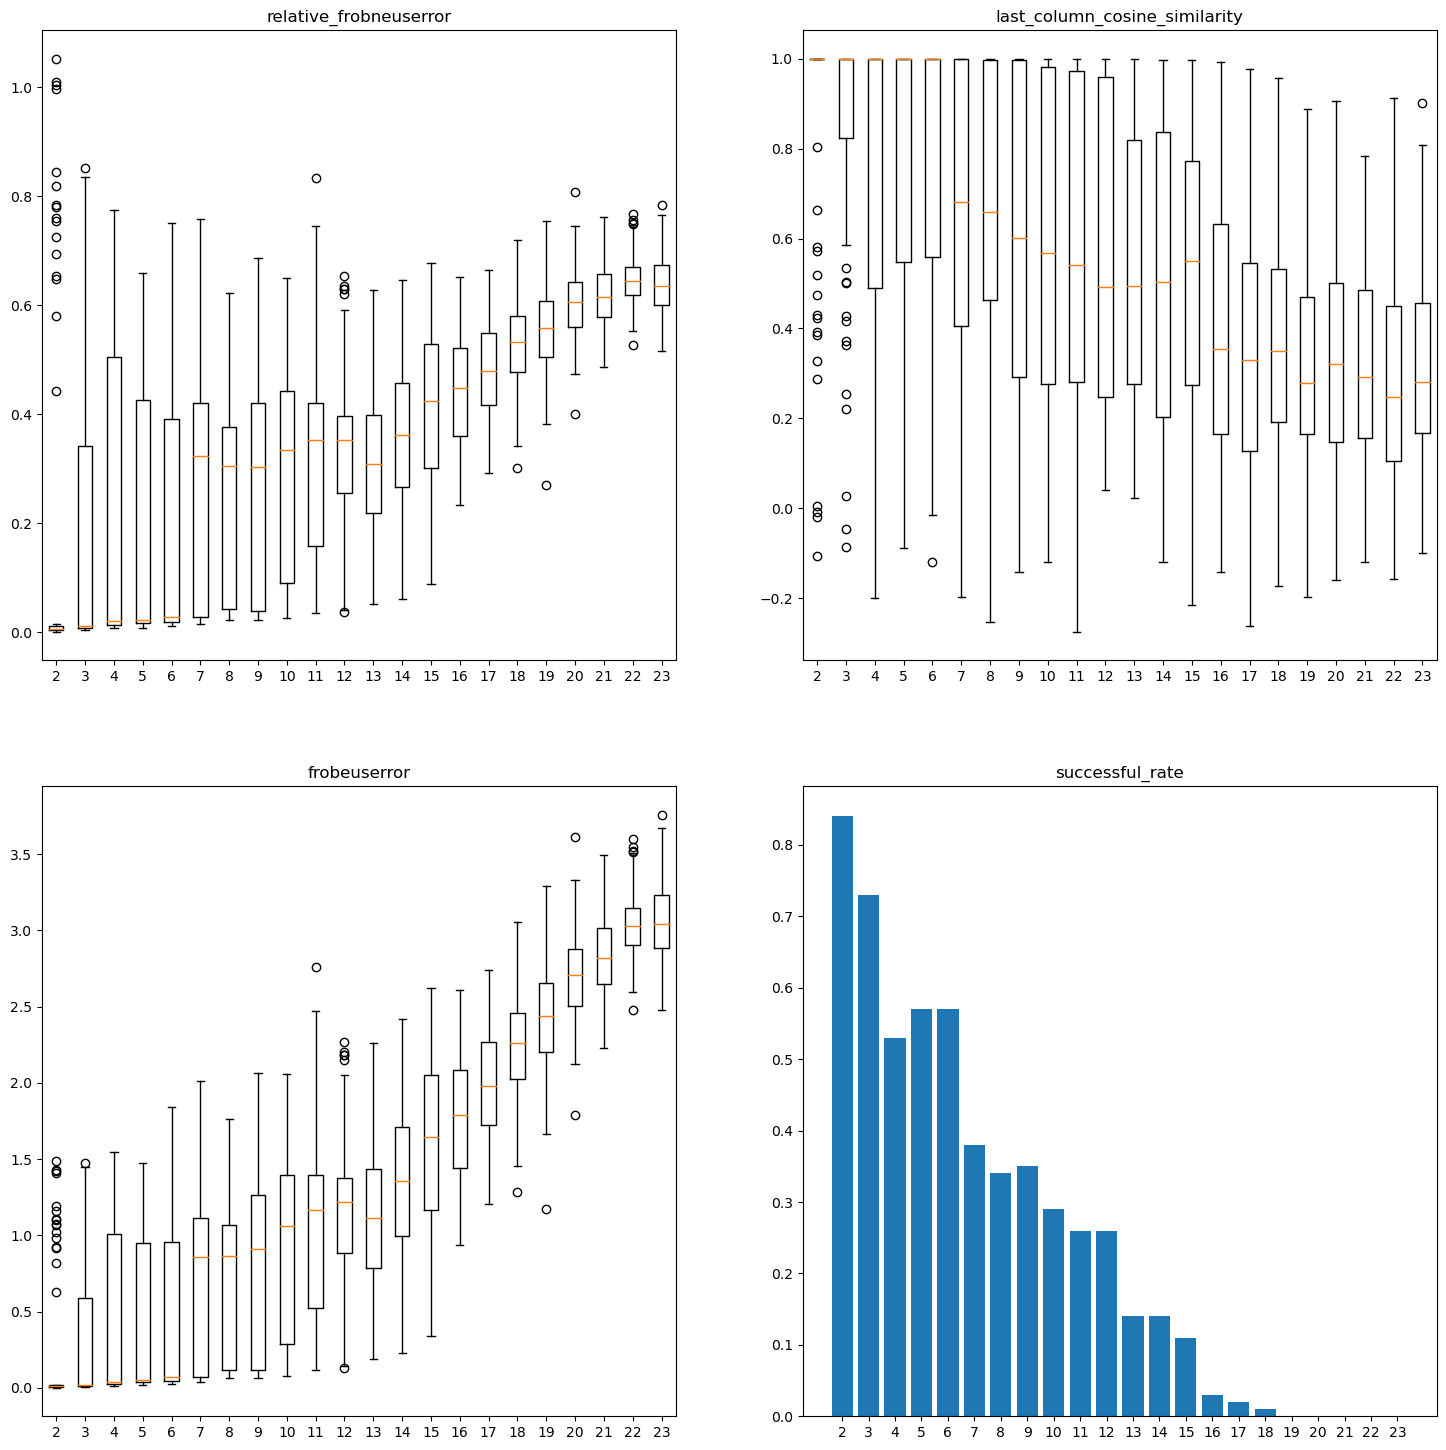

In [6]:
I=6
Jlist=Iequals6Jlist
n_iter=100
samplesize=100000
plot_graphs(I,Jlist,n_iter,samplesize,5)

In [ ]:
I=7
Jlist=Iequals7list
n_iter=100
samplesize=100000
plot_graphs(I,Jlist,n_iter,samplesize)

In [ ]:
I=8
Jlist=Iequals8list
n_iter=100
samplesize=100000
plot_graphs(I,Jlist,n_iter,samplesize)